# Tutorial 2 – Liquid Chromatography

Liquid chromatography (LC) separates peptides in time before they enter the mass spectrometer. By separating them first by LC, the mass spectrometer only needs to co-analyze smaller groups of peptides, increasing the overall accuracy and reliability of the results. In bottom-up proteomics we typically use **reverse-phase LC**, where the stationary phase is hydrophobic and the mobile phase gets gradually more organic. Hydrophobic peptides stick longer and elute later, while hydrophilic peptides elute early.

In this tutorial we recreate the LC step computationally: we start from the digested peptides, predict their retention times using a hydrophobicity model, and visualize how well the chromatographic gradient separates them.

## Objectives
- Learn why separating peptides via LC before MS improves detection accuracy.
- Use a retention time prediction model to estimate LC retention times based on peptide hydrophobicity.
- Plot histograms of predicted retention times to analyze how peptides are separated.
- Practice using external scientific libraries and Matplotlib for visualization.

---

## 1. Load the digested peptides
We start where Tutorial 1 ended: by reusing the pickled `digested_peptides_map` generated after protein digestion. Each entry maps a protein ID to the list of peptides produced by your chosen protease.

> 🚩 **Fill in the triple dots [...]**

In [22]:
import pickle

pickle_path = '../results/digested_peptides_map.pkl'  # e.g., 'results/digested_peptides_map.pkl'
with open(pickle_path, 'rb') as handle:
    digested_peptides_map = pickle.load(handle)

len(digested_peptides_map)

3

### 1.1 Pool peptides across proteins
For LC we only need the peptide list, not the protein grouping. Flatten the dictionary values into one list and report how many peptides you have in total.

> 🚩 **Fill in the triple dots [...]**

In [ ]:
# Different approaches:

# 1. sum()
pooled_peptides = sum(digested_peptides_map.values(), [])
print(f'Total peptides: {len(pooled_peptides)}')

# 2. itertools
import itertools
pooled_peptides = list(itertools.chain.from_iterable(digested_peptides_map.values()))
print(f'Total peptides: {len(pooled_peptides)}')

# 3. list comprehension
pooled_peptides = [
    peptide 
    for peptide_list in digested_peptides_map.values() 
    for peptide in peptide_list
]
print(f'Total peptides: {len(pooled_peptides)}')

# 4. for loop
pooled_peptides = []
for peptide_list in digested_peptides_map.values():
    for peptide in peptide_list:
        pooled_peptides.append(peptide)
print(f'Total peptides: {len(pooled_peptides)}')

Total peptides: 37
Total peptides: 37
Total peptides: 37
Total peptides: 37


---

## 2. Predict LC retention times with AI models
Modern LC-MS pipelines often rely on machine learning models that map peptide sequences to retention times by encoding amino-acid properties (hydrophobicity, charge, sequence motifs). Tools like DeepLC, Prosit, and ELUDE have become staples in proteomics workflows. In this tutorial we use the `pyteomics.achrom` model, which approximates reverse-phase LC behavior using well-characterized hydrophobicity coefficients.

In [24]:
# Install pyteomics if needed
!pip install -q pyteomics

from pyteomics import achrom

The variable ```achrom.RCs_guo_ph7_0``` specifies the use of a predefined set of retention coefficients based on experimental data from Guo et al., acquired at a pH of 7.0. These coefficients are suitable to estimate RTs of peptides under similar conditions. As a demonstration, below the relative retention time is computed for the example sequence ‘PEPTIDE’.

In [25]:
relative_RT = achrom.calculate_RT('PEPTIDE', achrom.RCs_guo_ph7_0)
print("The relative RT of the amino acid sequence PEPTIDE is: ", relative_RT)

The relative RT of the amino acid sequence PEPTIDE is:  7.800000000000001


## ⭐ Essential function: `predict_lc_retention_times`
Now let's make a function which takes a list of peptide sequences and returns a dictionary mapping each peptide to its predicted retention time (rounded to two decimals).

> 🚩 **Fill in the triple dots [...]**

In [26]:
def predict_lc_retention_times(peptides):
    """
    Predict LC retention times for a list of peptides using the Achrom model.

    Parameters
    ----------
    peptides : list of str
        List of peptide sequences.
    Returns
    -------
    dict
        A dictionary mapping each peptide to its predicted retention time.
    """

    rt_predictions = {}
    for peptide in peptides:
        rt = achrom.calculate_RT(peptide, achrom.RCs_guo_ph7_0)
        rt_predictions[peptide] = rt
    return rt_predictions

Now apply the function to our `pooled_peptides` list.

In [27]:
rt_map = predict_lc_retention_times(pooled_peptides)

rt_map

{'MATSR': np.float64(8.9),
 'YEPVAEIGVGAYGTVYK': np.float64(42.699999999999996),
 'DPHSGHFVALK': np.float64(29.0),
 'VPNGGGGGGGLPISTVR': np.float64(31.6),
 'EVALLR': np.float64(25.5),
 'LEAFEHPNVVR': np.float64(33.5),
 'LMDVCATSR': np.float64(23.6),
 'VTLVFEHVDQDLR': np.float64(41.00000000000001),
 'TYLDK': np.float64(11.1),
 'APPPGLPAETIK': np.float64(29.1),
 'GLDFLHANCIVHR': np.float64(47.50000000000001),
 'DLKPENILVTSGGTVK': np.float64(34.5),
 'LADFGLAR': np.float64(29.499999999999996),
 'IYSYQMALTPVVVTLWYR': np.float64(78.10000000000001),
 'APEVLLQSTYATPVDMWSVGCIFAEMFR': np.float64(96.19999999999999),
 'KPLFCGNSEADQLGK': np.float64(28.0),
 'IFDLIGLPPEDDWPR': np.float64(51.3),
 'DVSLPR': np.float64(14.700000000000001),
 'GAFPPR': np.float64(16.3),
 'GPRPVQSVVPEMEESGAQLLLEMLTFNPHK': np.float64(80.9),
 'ISAFR': np.float64(19.9),
 'ALQHSYLHK': np.float64(28.500000000000004),
 'DEGNPE': np.float64(-4.0),
 'MEDEEK': np.float64(-0.7000000000000004),
 'AVEILGNTEAAHPPSPIR': np.float64(43.80

What are the minimum and maximum RTs?

In [28]:
min_rt = min(rt_map.values())
max_rt = max(rt_map.values())

print(f'Min: {min_rt}')
print(f'Max: {max_rt}')

Min: -4.0
Max: 140.20000000000002


You might be wondering how there can be negative RTs?

This is because the prediction tool only provides relative RT values that need to be calibrated based on actually observed RTs of peptides in a given chromatographic setup. This will translate the relative and unitless RTs into actual RTs in minutes.

For this tutorial, we will however continue to work with relative RTs.

### ✅ Unit test: `predict_lc_retention_times`
Create a dummy peptide list, run your function, and assert the output matches the expected dictionary (rounded to two decimals).

> 🚩 **Fill in the triple dots [...]**

In [29]:
def test_predict_lc_retention_times():
    peptides = ['PEPTIDE', 'TEST', 'SAMPLE']
    expected = {
        'PEPTIDE': achrom.calculate_RT('PEPTIDE', achrom.RCs_guo_ph7_0),
        'TEST': achrom.calculate_RT('TEST', achrom.RCs_guo_ph7_0),
        'SAMPLE': achrom.calculate_RT('SAMPLE', achrom.RCs_guo_ph7_0)
    }

    actual = predict_lc_retention_times(peptides)
    assert actual == expected

test_predict_lc_retention_times()

---

## 3. Visualize retention time distributions
Plotting retention times as histograms shows how many peptides elute at different parts of the LC gradient. A smooth, broad distribution indicates that the chromatographic method separates peptides across the whole run, reducing MS undersampling.

We will use Matplotlib histograms where the x-axis is retention time (minutes) and the y-axis approximates intensity by counting how many peptides fall into each bin.

## ⭐ Essential function: `plot_retention_time`
Wrap the histogram plotting into a reusable function that accepts a list (or dict values) of retention times plus a `resolution` parameter controlling the number of histogram bins.

> 🚩 **Fill in the triple dots [...]**

In [30]:
import matplotlib.pyplot as plt

def plot_retention_time(retention_times, resolution=30):
    """
    Plot a histogram of predicted LC retention times.

    Parameters
    ----------
    retention_times : list of float
        List of predicted retention times.
    resolution : int, optional
        Number of bins in the histogram, by default 30. 
    Returns
    -------
    None
    """
    plt.hist(retention_times, bins=resolution)
    plt.xlabel('Predicted Retention Time')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted LC Retention Times')
    plt.show()

### Exercise: compare resolutions
Use your plotting function to visualize the same retention-time data twice—once with `resolution=30` bins and once with `resolution=60`. Describe how the bin size changes the appearance and interpretability of the chromatogram-like histogram.

> 🚩 **Fill in the triple dots [...]**

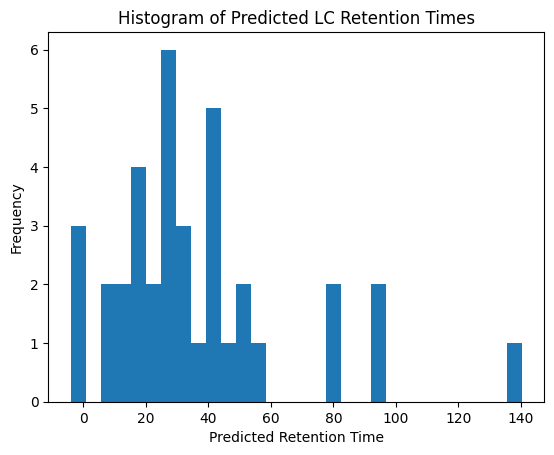

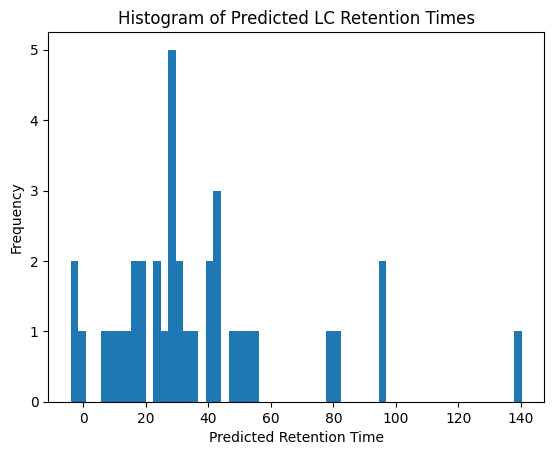

In [31]:
predicted_rts = predict_lc_retention_times(pooled_peptides)
retention_times = list(predicted_rts.values())
plot_retention_time(retention_times, resolution=30)
plot_retention_time(retention_times, resolution=60)

**Questions:**

- What do you see? How do peptides distribute across different bins?
- What happens if you increase the number of bins?
- Investigating different numbers of bins roughly mimics looking at different chromatographic resolutions or gradient lengths. Can you imagine how increasing the resolution impacts MS analysis?

---

## 4. Select a retention-time window
After predicting retention times, LC-MS/MS experiments typically focus on a specific time window for MS1/MS2 acquisition. Implementing a selection function lets us mimic that filtering step computationally.

The function will accept the retention-time dictionary and lower/upper bounds (in minutes) and return only the peptides that fall inside that window.

> 🚩 **Fill in the triple dots [...]**

In [ ]:
def select_retention_time_window(peptide_rt_map, lower_ret_time, upper_ret_time):
    """
    Select peptides within a specified retention time window.

    Parameters
    ----------
    peptide_rt_map : dict
        A dictionary mapping peptides to their predicted retention times.
    lower_ret_time : float
        Lower bound of the retention time window.
    upper_ret_time : float
        Upper bound of the retention time window.   
    Returns
    -------
    dict
        A dictionary of peptides and their retention times within the specified window.
    """
    # dict comprehension
    selected_peptides = {peptide: rt for peptide, rt in peptide_rt_map.items() if lower_ret_time <= rt <= upper_ret_time}
    return selected_peptides

In [47]:
def select_retention_time_window(peptide_rt_map, lower_ret_time, upper_ret_time):
    """
    Select peptides within a specified retention time window.

    Parameters
    ----------
    peptide_rt_map : dict
        A dictionary mapping peptides to their predicted retention times.
    lower_ret_time : float
        Lower bound of the retention time window.
    upper_ret_time : float
        Upper bound of the retention time window.   
    Returns
    -------
    dict
        A dictionary of peptides and their retention times within the specified window.
    """
    # for loop
    selected_peptides = {}
    for peptide, rt in peptide_rt_map.items():
        if lower_ret_time <= rt <= upper_ret_time:
            selected_peptides[peptide] = rt
    return selected_peptides

### 4.1 Apply the window filter
Use your function to select peptides that elute between 0 and 20 minutes. Store them in `select_peps` — this subset will feed into the MS1 simulation in the next tutorial.

> 🚩 **Fill in the triple dots [...]**

In [48]:
select_peps = select_retention_time_window(
    peptide_rt_map=predicted_rts,
    lower_ret_time=0,
    upper_ret_time=20,
)

len(select_peps)

8

### ✅ Unit test: `select_retention_time_window`
Create a small retention-time dictionary (2–3 peptides) and assert that the helper returns exactly those peptides that fall within a chosen window. Also test that peptides outside the range are excluded.

> 🚩 **Fill in the triple dots [...]**

In [49]:
def test_select_retention_time_window():
    peptide_rt_map = {"PEP": 10.0, "TIDE": 25.0, "RT": 15.5, "TEST": -3.0}
    selected = select_retention_time_window(peptide_rt_map, lower_ret_time=0, upper_ret_time=20)

    assert selected == {"PEP": 10.0, "RT": 15.5}

test_select_retention_time_window()

---

## 5. Save the selected peptides
Persist the `select_peps` list so you can reuse it in the MS tutorial. Saving it as a pickle file avoids recomputing the retention times if you tweak parameters later.

### 5.1 Write to disk

> 🚩 **Fill in the triple dots [...]**

In [36]:
import pickle
output_path = '../results/select_peptides.pkl'
with open(output_path, 'wb') as file:
    pickle.dump(select_peps, file)